# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR

import mujoco_py
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2)
print(dynamics.dt)

0.04


In [7]:
# Note that the augmented state is not all 0.
x_goal = np.array([0.0, 0.0, 0.0, 1.0, 0.0])
print(x_goal)

# Instantenous state cost.
Q = np.eye(5)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = 1
Q[2, 2] = Q[3, 3] = 1**2
R = 0.1 * np.eye(1)

# Terminal state cost.
Q_terminal = 100 * np.eye(5)

# Instantaneous control cost.
R = np.array([[0.1]])

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

[0. 0. 0. 1. 0.]


In [8]:
cost2 = FiniteDiffCost(lambda x, u, i: x[0]*(x[0]+np.sin(x[1])) + np.sin(x[1])*(x[0] + np.sin(x[1])) + (np.cos(x[1]) - 1) * (np.cos(x[1])-1) + 0.1 * u[0] * u[0],
                      lambda x, i: 100 * (x[0]**2 + x[2]**2 + np.sin(x[1])**2 + (np.cos(x[1]) - 1)**2 + x[3]**2),
                      4, 1, x_eps = 1e-6, u_eps = 1e-6)

print(cost1.l([1.0,0.5,np.sin(0.37),np.cos(0.37),3.0], [0.5], 0))
print(cost2.l([1.0,0.37,0.5,3.0], [0.5], 0))

1.883576172717855
1.883576172717855


In [11]:
N = 100
x0 = np.array([0.0, 0.0, 0.0, 0.0])
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost2, N)

In [12]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 failed 674.9461979431098 [-0.69791744 -1.22697491  0.49067155  1.09898821]
iteration 1 failed 674.9461979431098 [-0.69791744 -1.22697491  0.49067155  1.09898821]
iteration 2 failed 674.9461979431098 [-0.69791744 -1.22697491  0.49067155  1.09898821]
iteration 3 failed 674.9461979431098 [-0.69791744 -1.22697491  0.49067155  1.09898821]
iteration 4 failed 674.9461979431098 [-0.69791744 -1.22697491  0.49067155  1.09898821]
iteration 5 failed 674.9461979431098 [-0.69791744 -1.22697491  0.49067155  1.09898821]


In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

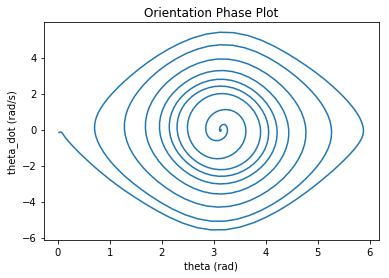

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

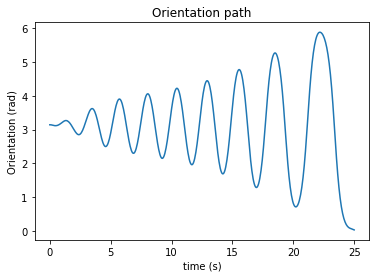

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

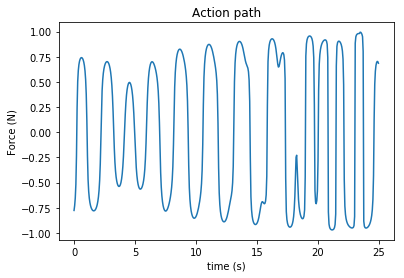

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

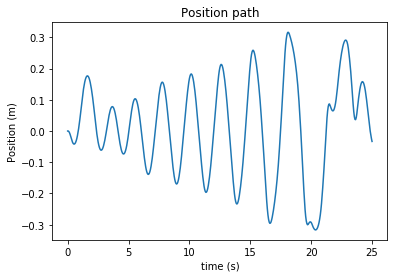

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

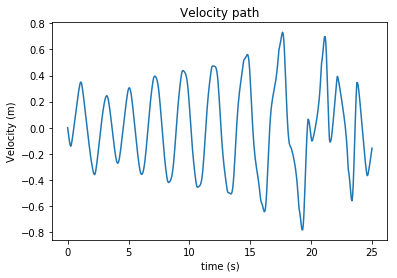

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

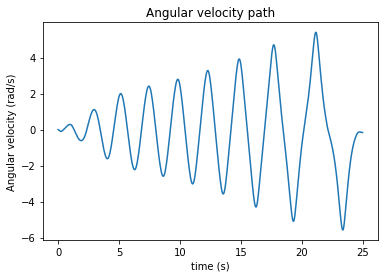

In [17]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

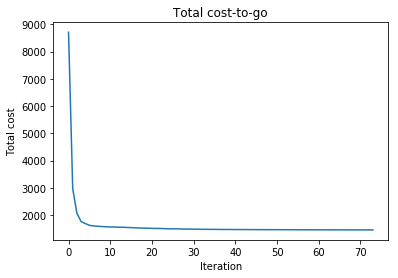

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")